In [2]:
import git
repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
%cd $dir_path

/data/reventh/habitat-lab


/data/reventh/anaconda3/envs/habitat/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
from dataclasses import dataclass

import magnum as mn
import sys
import random
import json
import re
from PIL import Image
import numpy as np
import os
import habitat
from habitat.config.default_structured_configs import ActionConfig
from habitat.tasks.nav.nav import SimulatorTaskAction

/data/reventh/anaconda3/envs/habitat/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# This is the configuration for our action.
@dataclass
class StrafeActionConfig(ActionConfig):
    move_amount: float = 0.0  # We will change this in the configuration
    strafe_angle_deg: int = 0

# This is a helper that implements strafing that we will use in our actions
def _strafe_body(
    sim,
    move_amount: float,
    strafe_angle_deg: int
):
    # Get the state of the agent
    agent_state = sim.get_agent_state()
    # Convert from np.quaternion (quaternion.quaternion) to mn.Quaternion
    normalized_quaternion = agent_state.rotation
    agent_mn_quat = mn.Quaternion(
        normalized_quaternion.imag, normalized_quaternion.real
    )
    forward = agent_mn_quat.transform_vector(-mn.Vector3.z_axis())
    strafe_angle = strafe_angle_deg
    strafe_angle = mn.Deg(strafe_angle)
    rotation = mn.Quaternion.rotation(strafe_angle, mn.Vector3.y_axis())
    move_amount = move_amount
    delta_position = rotation.transform_vector(forward) * move_amount
    final_position = sim.pathfinder.try_step(  # type: ignore
        agent_state.position, agent_state.position + delta_position
    )
    sim.set_agent_state(
        final_position,
        [*rotation.vector, rotation.scalar],
        reset_sensors=False,
    )


# We define and register our actions as follows.
# the __init__ method receives a sim and config argument.
@habitat.registry.register_task_action
class StrafeRand(SimulatorTaskAction):
    def __init__(self, *args, config, sim, **kwargs):
        super().__init__(*args, config=config, sim=sim, **kwargs)
        self._sim = sim
        self._move_amount = config.move_amount
        self._strafe_angle_deg = config.strafe_angle_deg

    def _get_uuid(self, *args, **kwargs) -> str:
        return "strafe_rand"

    def step(self, *args, **kwargs):
        print(
            f"Calling {self._get_uuid()} d={self._move_amount}m noise={self._strafe_angle_deg}"
        )
        # This is where the code for the new action goes. Here we use a
        # helper method but you could directly modify the simulation here.
        _strafe_body(self._sim, self._move_amount, self._strafe_angle_deg)

In [5]:
config = habitat.get_config(
        config_path="benchmark/nav/pointnav/pointnav_habitat_test.yaml"
    )

move_amount = np.random.uniform(-50, 50)
str_angle_deg = int(np.random.normal(0, 45))
if move_amount>=0:
        tinst = f"move forward by {move_amount} steps"
else:
        tinst = f"move backward by {move_amount} steps"
    
if str_angle_deg>=0:
        rinst = f"rotate left by {str_angle_deg} degrees"
else:
        rinst = f"rotate right by {str_angle_deg} degrees"

instruction = f"{rinst} and {tinst}"

print(instruction)



with habitat.config.read_write(config):
        # Add a simple action config to the config.habitat.task.actions dictionary
        # Here we do it via code, but you can easily add them to a yaml config as well
        config.habitat.task.actions["STRAFE_RAND"] = StrafeActionConfig(
            type="StrafeRand",
            move_amount=move_amount,
            strafe_angle_deg=str_angle_deg,
        )

rotate right by -1 degrees and move forward by 47.305613437826295 steps


In [6]:
def display_sample(rgb_obs): 
    rgb_img = Image.fromarray(rgb_obs, mode="RGB")
    return rgb_img

In [7]:
env = habitat.Env(config=config)
obs1 = env.reset()


2024-02-17 11:07:26,057 Initializing dataset PointNav-v1
2024-02-17 11:07:26,335 initializing sim Sim-v0
[11:07:26:590491]:[Warning]:[Assets] ResourceManager.cpp(369)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SceneInstanceAttributes-provided name : `data/scene_datasets/habitat-test-scenes/skokloster-castle.scn` nor constructed filename : `data/scene_datasets/habitat-test-scenes/info_semantic.json` exist on disk.
2024-02-17 11:07:27,478 Initializing task Nav-v0
[11:07:27:474726]:[Warning]:[Sim] Simulator.cpp(533)::instanceStageForSceneAttributes : The active scene does not contain semantic annotations : activeSemanticSceneID_ = 0


Renderer: NVIDIA GeForce RTX 3090/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 535.129.03
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


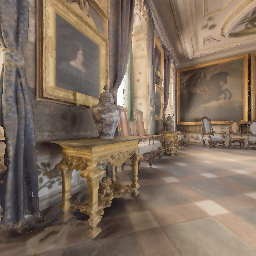

In [8]:
obs1 = env.reset()
display_sample(obs1["rgb"])